In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [70]:
df = pd.read_csv('data/stud.csv')

In [71]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Seperando as variáveis X e Y

In [72]:
X = df.drop(columns=['math_score'],axis=1)
X.head(3)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93


In [74]:
y = df[['math_score']]
y.head(3)

,math_score
0,72
1,69
2,90


In [75]:
# guardando as variáveis numéricas de X
num_features = X.select_dtypes(exclude='object').columns
# guardando as variáveis categóricas de X
cat_features = X.select_dtypes(include="object").columns

## Featuring Encoder

In [21]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

Pipeline para as variávies numéricas

In [76]:
num_pipeline=Pipeline(
                steps=[
                    ('imputer',SimpleImputer(strategy='median')), # substitui os ausentes pela média da coluna
                    ('scaler',StandardScaler(with_mean=False))
                ]
)

Pipeline para as variáveis categóricas

In [78]:
cat_pipeline=Pipeline(
                steps=[
                    ('imputer',SimpleImputer(strategy='most_frequent')), # substitui os ausentes pelo mais frequente na coluna
                    ('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))
                ]
)

ColumnTransformer para aplicar as transformações

In [79]:
preprocessor=ColumnTransformer(
                [
                    ("num_pipeline",num_pipeline,num_features),
                    ("cat_pipelines",cat_pipeline, cat_features)
                ],
    remainder='drop'
)

### Separando em treino e teste

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 7), (200, 7))

In [81]:
from sklearn import set_config
set_config(display='diagram')
display(preprocessor)

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 Index(['reading_score', 'writing_score'], dtype='object')),
                                ('cat_pipelines',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course'],
      dtype='object'))])

## Aplicando as transformações

In [82]:
X_train = preprocessor.fit_transform(X_train)
X_train

array([[4.84345595, 4.97482382, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [5.74295491, 5.50547169, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [6.15810828, 5.70446464, 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [4.28991813, 3.51554216, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [3.32122694, 3.51554216, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [6.29649274, 5.90345759, 1.        , ..., 1.        , 0.        ,
        1.        ]])

In [83]:
X_test = preprocessor.transform(X_test)
X_test

array([[5.9505316 , 5.57180267, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [4.56668704, 4.84216185, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [5.05103263, 4.77583086, 0.        , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [5.60457046, 5.0411548 , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [5.32780155, 4.90849283, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [5.12022486, 4.77583086, 1.        , ..., 1.        , 1.        ,
        0.        ]])

## Treinando e avaliando os modelos

In [84]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [85]:
model_list = []
r2_list =[]

In [86]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

In [87]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- R2 Score: 0.8804


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5925
- Mean Absolute Error: 5.2053
- R2 Score: 0.8072
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5173
- Mean Absolute Error: 5.1557
- R2 Score: 0.8254


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.6960
- Mean Absolute Error: 4.5023
- R2 Score: 0.8561
-----------------------

### Resultados

In [88]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880592
0,Linear Regression,0.880433
8,AdaBoost Regressor,0.852875
7,CatBoosting Regressor,0.851831
5,Random Forest Regressor,0.851784
1,Lasso,0.825447
6,XGBRegressor,0.819688
3,K-Neighbors Regressor,0.786315
4,Decision Tree,0.736293


Regressão Linear

In [89]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.04


Plot y_pred and y_test - Previsto x Real

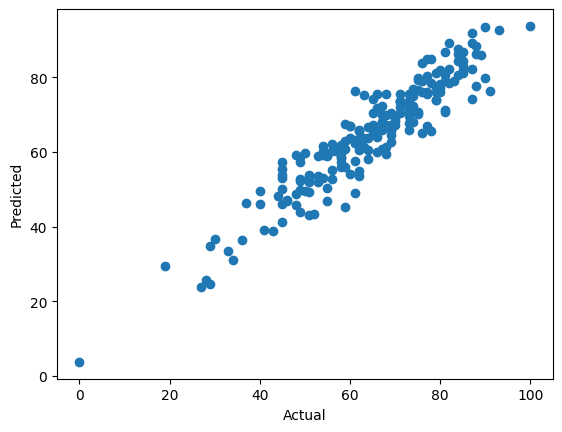

In [100]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

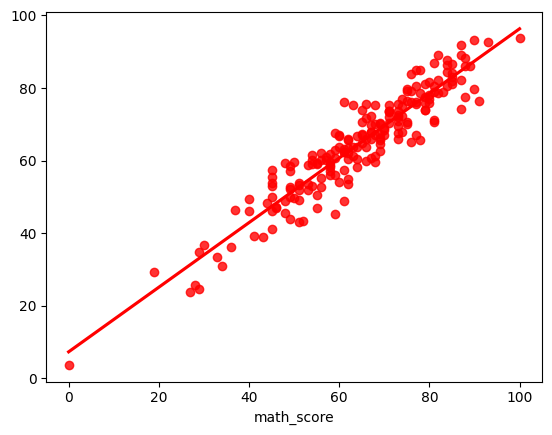

In [101]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

Diferença entre os valores reais e os previstos

In [120]:
pred_df=pd.DataFrame({'Actual Value':y_test.values.flatten(),'Predicted Value':y_pred.flatten(),'Difference':y_test.values.flatten()-y_pred.flatten()})
pred_df

,Actual Value,Predicted Value,Difference
0,91,76.387970,14.612030
1,53,58.885970,-5.885970
2,80,76.990265,3.009735
3,74,76.851804,-2.851804
4,84,87.627378,-3.627378
...,...,...,...
195,52,43.409149,8.590851
196,62,62.152214,-0.152214
197,74,67.888395,6.111605
198,65,67.022287,-2.022287
